# Im2Spec models for predicting property (spectrum) from structure (image)

*  *The experimental STEM EELS data was collected by Jordan Hachtel and Kevin Roccapriore*

---

This notebook demonstrates usage of encoder-decoder neural networks for predicting spectra (property/functionality) from images (structure) using the *im2spec* deep learning model. In the *im2spec* approach, the sub-images representing a local structure are “compressed” via a convolutional neural network architecture to the small number of latent variables, and the latter are “deconvoluted” to yield the spectra. The architecture of the *im2spec* model is straightforward. It consists of two parts: an encoder for embedding input images into a latent vector and a decoder for generating one-dimensional signals from the embedded features. The encoder part consists of three back-to-back two-dimensional convolutional layers, whereas the decoder part represents a cascade of one-dimensional dilated convolutions with dilation rates of 1, 2, 3, and 4. The dilated convolutions showed superior performance compared to regular convolutional blocks in the decoder. Each convolutional layer in both encoder and decoder parts is formed by running 64 filters (“kernels”) of size 3 on its input and is activated by a leaky rectified linear unit with a negative slope of 0.1. The batch normalization is applied after each activation to avoid overfitting and improve generalization to new data. The “bottleneck” layer for representing the latent vector is a fully connected layer with the number of neurons equal to the specified number of latent dimensions.

<img src="https://drive.google.com/uc?export=view&id=18cvXfDdpy1Ij-p1T-jALa_nBZ0iRsalW" width=800 px><br><br>


The assumption is of course that there is only a small variability of spectral behaviour within each (sub)-image. Here we are going to apply the *imspec* approach to the dataset: i) STEM EELS dataset obtained by Jordan Hachtel. For the details of training/test data preparation, see [this](https://arxiv.org/pdf/2006.01374.pdf) and [this](https://arxiv.org/pdf/2009.09005.pdf) papers.


---


## Original AtomAI

Install AtomAI:

In [1]:
!pip install git+https://github.com/Hitesh1309/atomai@master # install the latest version from source

  Cloning https://github.com/Hitesh1309/atomai (to revision master) to /tmp/pip-req-build-j_66xvp_
  Running command git clone --filter=blob:none --quiet https://github.com/Hitesh1309/atomai /tmp/pip-req-build-j_66xvp_
  Resolved https://github.com/Hitesh1309/atomai to commit 1bea728ae9d9a79a58e3d6f2a19979279a4c47aa
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | / done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 2.5 MB/s eta 0:00:00
  Created wheel for atomai: filename=atomai-0.7.8.1.1-py3-none-any.whl size=165293 sha256=09996af04fd810a418026b10cdfb47f40a90a53cc72bdc8d21883df4dec55253
  Stored in directory: /tmp/pip

Imports:

In [2]:
import atomai as aoi
import numpy as np
import matplotlib.pyplot as plt

## Application to STEM EELS data

(Down)load data:

In [3]:
!pip install gdown

In [4]:
!gdown -O "eels_imspec.npz" https://drive.google.com/uc?id=1BprChho_y-LdVQstR1vYzCxmK677algR

Downloading...
From (original): https://drive.google.com/uc?id=1BprChho_y-LdVQstR1vYzCxmK677algR
From (redirected): https://drive.google.com/uc?id=1BprChho_y-LdVQstR1vYzCxmK677algR&confirm=t&uuid=24ca2b08-027d-488a-b50b-87807eea912e
To: /kaggle/working/eels_imspec.npz
100%|███████████████████████████████████████| 50.1M/50.1M [00:00<00:00, 181MB/s]


In [5]:
dataset = np.load('eels_imspec.npz')
dataset

NpzFile 'eels_imspec.npz' with keys: images, spectra, indices, full_image

In [6]:
imgs = dataset['images']
spectra = dataset['spectra']
# specval = dataset['specval']

In [7]:
imgs.shape

(2714, 16, 16)

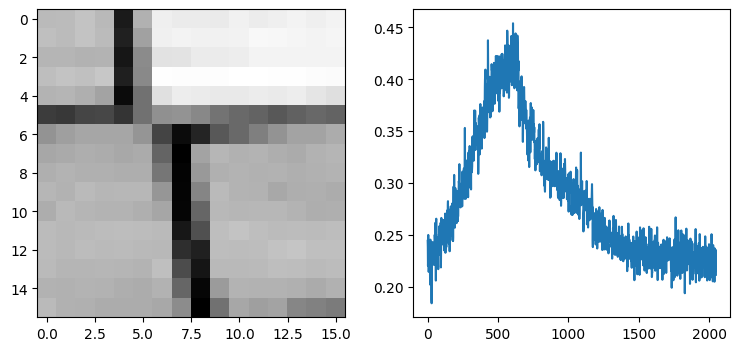

In [8]:
k = 12
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1.imshow(imgs[k], cmap='gray')
ax2.plot(spectra[k])

Train-test split:

In [9]:
imgs_train, spectra_train, imgs_test, spectra_test = aoi.utils.data_split(imgs, spectra, format_out="torch_float")

Initialize and train ImSpec model (same parameters as above):

In [10]:
in_dim = (16, 16)
out_dim = (2048,)

model = aoi.models.ImSpec(in_dim, out_dim, latent_dim=10, seed=2)

model.net

SignalED(
  (encoder): SignalEncoder(
    (conv): ConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.1)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.1)
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): LeakyReLU(negative_slope=0.1)
        (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (fc): Linear(in_features=16384, out_features=10, bias=True)
  )
  (decoder): SignalDecoder(
    (fc): Linear(in_features=10, out_features=131072, bias=True)
    (dilblock): DilatedBlock(
      (atrous_module): Sequential(
        (0): Conv1d(64, 64, 

/opt/conda/lib/python3.10/site-packages/atomai/utils/preproc.py:87: UserWarning: Adding a channel dimension of 1 to training images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/atomai/utils/preproc.py:92: UserWarning: Adding a channel dimension of 1 to test images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/atomai/utils/preproc.py:97: UserWarning: Adding a channel dimension of 1 to training spectra
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/atomai/utils/preproc.py:102: UserWarning: Adding a channel dimension of 1 to test spectra
  warnings.warn(


Epoch 1/500 ... Training loss: 1.442547 ... Test loss: 1.583135 ... GPU memory usage: 1280/16384
Epoch 2/500 ... Training loss: 1.295688 ... Test loss: 1.13591 ... GPU memory usage: 1280/16384
Epoch 3/500 ... Training loss: 1.190206 ... Test loss: 1.160237 ... GPU memory usage: 1280/16384
Epoch 4/500 ... Training loss: 1.094454 ... Test loss: 1.107427 ... GPU memory usage: 1280/16384
Epoch 5/500 ... Training loss: 1.007614 ... Test loss: 0.995454 ... GPU memory usage: 1280/16384
Epoch 6/500 ... Training loss: 0.927967 ... Test loss: 0.90941 ... GPU memory usage: 1280/16384
Epoch 7/500 ... Training loss: 0.854744 ... Test loss: 0.852031 ... GPU memory usage: 1280/16384
Epoch 8/500 ... Training loss: 0.787867 ... Test loss: 0.798267 ... GPU memory usage: 1280/16384
Epoch 9/500 ... Training loss: 0.727019 ... Test loss: 0.703841 ... GPU memory usage: 1280/16384
Epoch 10/500 ... Training loss: 0.670794 ... Test loss: 0.661453 ... GPU memory usage: 1280/16384
Epoch 11/500 ... Training loss:

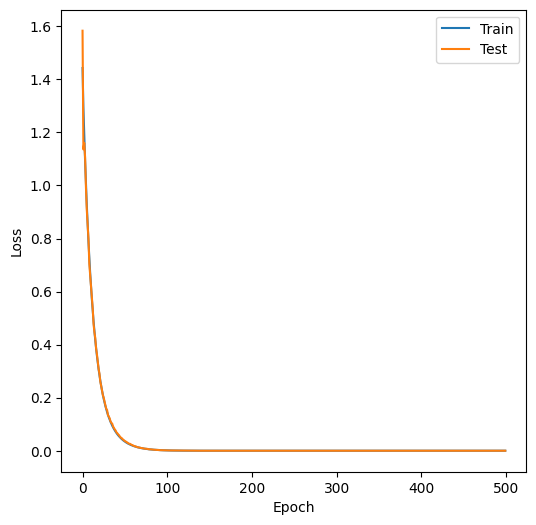

In [11]:
model.fit(imgs_train, spectra_train, imgs_test, spectra_test,  # training data
          full_epoch=True, training_cycles=500, swa=True, batch_norm=True, ES=False)  # training parameters

Make prediciton on test data:

In [12]:
prediction = model.predict(imgs_test, norm=False)

Batch 10/10
408 images were decoded in approximately 1.7082 seconds


Visualize for selected test image:

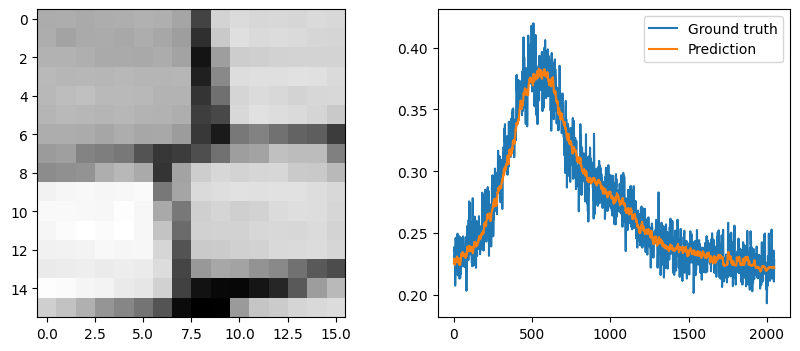

In [13]:
k = 10

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(imgs_test[k], cmap='gray', label="Input image")
ax2.plot(spectra_test[k], label="Ground truth")
ax2.plot(prediction[k], label="Prediction")
plt.legend()

---

## AtomAI with Early Stopping

Initialize and train ImSpec model with Early Stopping (same parameters as above):

/opt/conda/lib/python3.10/site-packages/atomai/utils/preproc.py:87: UserWarning: Adding a channel dimension of 1 to training images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/atomai/utils/preproc.py:92: UserWarning: Adding a channel dimension of 1 to test images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/atomai/utils/preproc.py:97: UserWarning: Adding a channel dimension of 1 to training spectra
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/atomai/utils/preproc.py:102: UserWarning: Adding a channel dimension of 1 to test spectra
  warnings.warn(


Epoch 1/500 ... Training loss: 1.442547 ... Test loss: 1.583135 ... GPU memory usage: 1338/16384
Updating ES model @ Epoch 1/500 ... Training loss: 1.442547 ... Test loss: 1.583135 ... GPU memory usage: 1338/16384
Epoch 2/500 ... Training loss: 1.295688 ... Test loss: 1.13591 ... GPU memory usage: 1340/16384
Updating ES model @ Epoch 2/500 ... Training loss: 1.295688 ... Test loss: 1.13591 ... GPU memory usage: 1340/16384
Epoch 3/500 ... Training loss: 1.190206 ... Test loss: 1.160237 ... GPU memory usage: 1340/16384
Epoch 4/500 ... Training loss: 1.094454 ... Test loss: 1.107427 ... GPU memory usage: 1340/16384
Updating ES model @ Epoch 4/500 ... Training loss: 1.094454 ... Test loss: 1.107427 ... GPU memory usage: 1340/16384
Epoch 5/500 ... Training loss: 1.007614 ... Test loss: 0.995454 ... GPU memory usage: 1340/16384
Updating ES model @ Epoch 5/500 ... Training loss: 1.007614 ... Test loss: 0.995454 ... GPU memory usage: 1340/16384
Epoch 6/500 ... Training loss: 0.927967 ... Test 

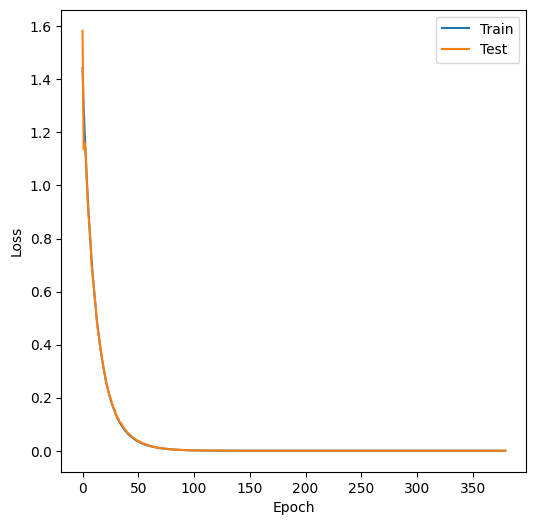

In [14]:
in_dim = (16, 16)
out_dim = (2048,)

es_model = aoi.models.ImSpec(in_dim, out_dim, latent_dim=10, seed=2)

es_model.fit(imgs_train, spectra_train, imgs_test, spectra_test,  # training data
          full_epoch=True, training_cycles=500, swa=False, ES=True, batch_norm=True, verbose=True)  # training parameters

Make prediciton on test data:

In [15]:
prediction = es_model.predict(imgs_test, norm=False)

Batch 10/10
408 images were decoded in approximately 1.7062 seconds


Visualize for selected test image:

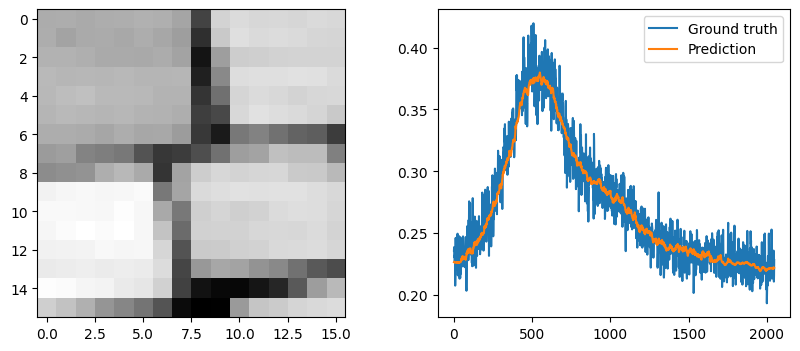

In [16]:
k = 10

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(imgs_test[k], cmap='gray', label="Input image")
ax2.plot(spectra_test[k], label="Ground truth")
ax2.plot(prediction[k], label="Prediction")
plt.legend()

---

## AtomAI with LSTM Decoder and Early Stopping

In [17]:
in_dim = (16, 16)
out_dim = (2048,)

lstm_model = aoi.models.ImSpecLSTM(in_dim, out_dim, latent_dim=10)

lstm_model.net

SignalED_LSTM(
  (encoder): SignalEncoder(
    (conv): ConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.1)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.1)
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): LeakyReLU(negative_slope=0.1)
        (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (fc): Linear(in_features=16384, out_features=10, bias=True)
  )
  (decoder): SignalDecoderLSTM(
    (fc): Linear(in_features=10, out_features=131072, bias=True)
    (lstm): LSTM(64, 256, num_layers=4, batch_first=True)
    (out): Linear(in_featu

/opt/conda/lib/python3.10/site-packages/atomai/utils/preproc.py:87: UserWarning: Adding a channel dimension of 1 to training images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/atomai/utils/preproc.py:92: UserWarning: Adding a channel dimension of 1 to test images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/atomai/utils/preproc.py:97: UserWarning: Adding a channel dimension of 1 to training spectra
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/atomai/utils/preproc.py:102: UserWarning: Adding a channel dimension of 1 to test spectra
  warnings.warn(


Epoch 1/500 ... Training loss: 0.022155 ... Test loss: 0.002711 ... GPU memory usage: 4352/16384
Updating ES model @ Epoch 1/500 ... Training loss: 0.022155 ... Test loss: 0.002711 ... GPU memory usage: 4352/16384
Epoch 2/500 ... Training loss: 0.001613 ... Test loss: 0.001615 ... GPU memory usage: 4362/16384
Updating ES model @ Epoch 2/500 ... Training loss: 0.001613 ... Test loss: 0.001615 ... GPU memory usage: 4362/16384
Epoch 3/500 ... Training loss: 0.001293 ... Test loss: 0.001383 ... GPU memory usage: 4362/16384
Updating ES model @ Epoch 3/500 ... Training loss: 0.001293 ... Test loss: 0.001383 ... GPU memory usage: 4362/16384
Epoch 4/500 ... Training loss: 0.00104 ... Test loss: 0.000817 ... GPU memory usage: 4362/16384
Updating ES model @ Epoch 4/500 ... Training loss: 0.00104 ... Test loss: 0.000817 ... GPU memory usage: 4362/16384
Epoch 5/500 ... Training loss: 0.000565 ... Test loss: 0.00058 ... GPU memory usage: 4362/16384
Updating ES model @ Epoch 5/500 ... Training loss:

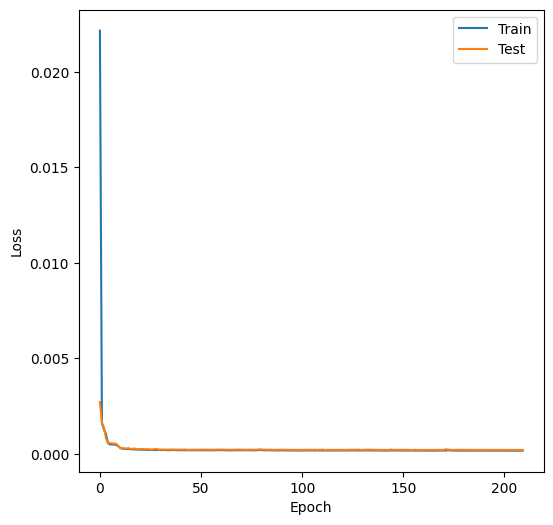

In [18]:
lstm_model.fit(imgs_train, spectra_train, imgs_test, spectra_test,  # training data
          full_epoch=True, training_cycles=500, swa=False, ES=True, batch_norm=True, verbose=True)  # training parameters